In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
from datetime import datetime, timedelta
from sklearn import linear_model, svm, tree, metrics
from sklearn.preprocessing import MinMaxScaler
from pylab import rcParams
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
##### load data sets
os.chdir('/home/roman/Documents/Projects/Bubbles')
datasets_original = ['^GSPC.csv', '^N225.csv', '000001.SS.csv']
dataset_names = ['S&P 500', 'N225', 'SSE']
datasets = []
for d in datasets_original:
    data_original = pd.read_csv(d, index_col = 'Date')
    data_original.index = pd.to_datetime(data_original.index, format='%Y/%m/%d')
    data_norm = data_original['Close'] / data_original['Close'][-1]
    data_ch = data_original['Close'].pct_change()
    window = 10
    data_vol = data_original['Close'].pct_change().rolling(window).std()
    data = pd.concat([data_original['Close'], data_norm, data_ch, data_vol], axis=1).dropna()
    data.columns = ['price', 'norm', 'ch', 'vol']
    datasets.append(data)
datasets[2] = datasets[2].loc['1995-06':,:] #<-- SSE only from 1995 fwd

In [3]:
##### find crashes
drawdowns = []
crashes = []
crash_thresholds = [-0.11, -0.11, -0.115]
for df, ct in zip(datasets, crash_thresholds):
    # find drawdowns (consecutive price decreases)
    pmin_pmax = (df['price'].diff(-1) > 0).astype(int).diff() #<- -1 indicates pmin, +1 indicates pmax
    pmax = pmin_pmax[pmin_pmax == 1]
    pmin = pmin_pmax[pmin_pmax == -1]
    # make sure drawdowns start with pmax, end with pmin:
    if pmin.index[0] < pmax.index[0]:
        pmin = pmin.drop(pmin.index[0])
    if pmin.index[-1] < pmax.index[-1]:
        pmax = pmax.drop(pmax.index[-1])
    D = (np.array(df['price'][pmin.index]) - np.array(df['price'][pmax.index])) \
    / np.array(df['price'][pmax.index])
    d = {'Date':pmax.index, 'drawdown':D, 'd_start': pmax.index, 'd_end': pmin.index}    
    df_d = pd.DataFrame(d).set_index('Date')
    df_d.index = pd.to_datetime(df_d.index, format='%Y/%m/%d')
    df_d = df_d.reindex(df.index).fillna(0)
    df_d = df_d.sort_values(by='drawdown')
    df_d['rank'] = list(range(1,df_d.shape[0]+1))
    drawdowns.append(df_d)
    df_d = df_d.sort_values(by='Date')
    df_c = df_d[df_d['drawdown'] < ct]
    df_c.columns = ['drawdown', 'crash_st', 'crash_end', 'rank']
    c_st = list(df_c['crash_st'])
    d_st = [df['price'][(c_s-timedelta(int(252*5/12))):c_s].idxmax() for c_s in c_st] 
    d_st_adj = [max(d, c_prev) for d, c_prev in zip(d_st[1:], c_st[:-1])]
    d_st_adj = [d_st[0]] + d_st_adj
    df_c['down_st'] = d_st_adj
    crashes.append(df_c)
df_combined = []  
for i in range(len(datasets)):
    df_combined.append(pd.concat([datasets[i], drawdowns[i]], axis=1))

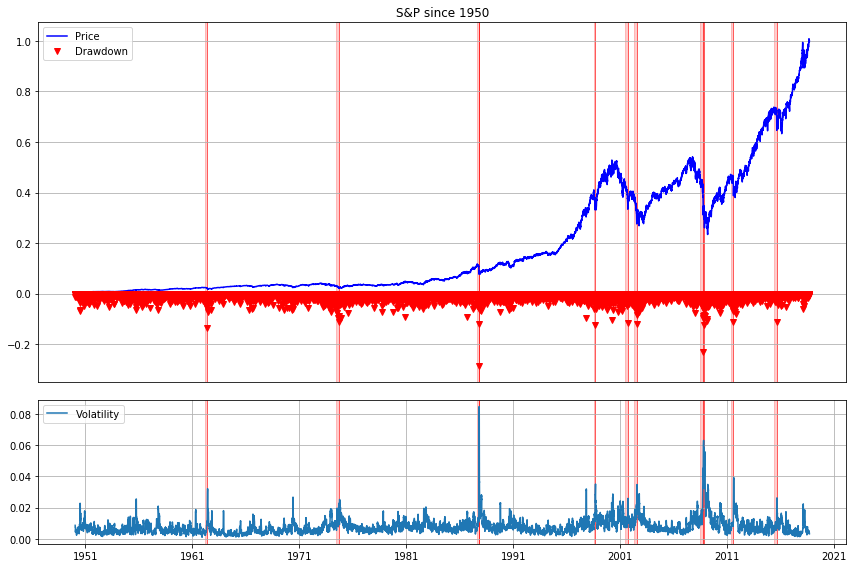

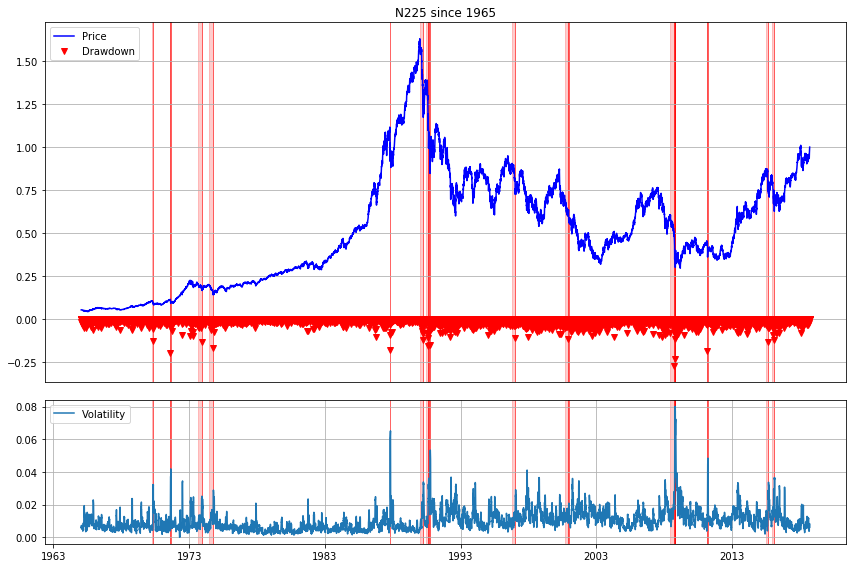

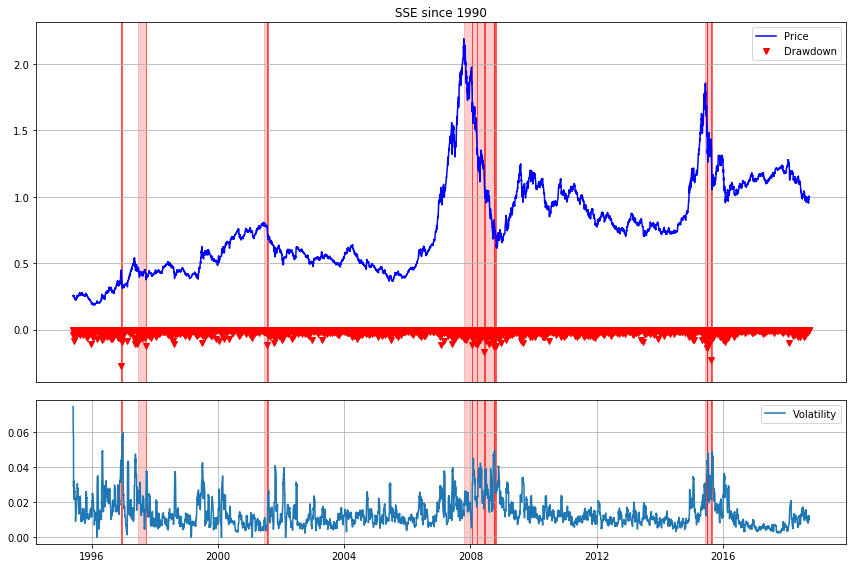

In [4]:
##### plot prices, crashes, volatility since beginning for each df
rcParams['figure.figsize'] = 12, 8
plt_titles = ['S&P since 1950', 'N225 since 1965', 'SSE since 1990']
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 
for i in range(len(df_combined)):
    plt.subplot(gs[0])
    plt.plot(df_combined[i]['norm'], color='blue')
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(crashes[i]['down_st'], \
         crashes[i]['crash_st'])]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.plot(df_combined[i]['drawdown'], color='red', marker='v',linestyle='')
    plt.title(plt_titles[i])
    plt.grid()
    plt.xticks([])
    plt.legend(['Price', 'Drawdown'])
    plt.subplot(gs[1])
    plt.plot(df_combined[i]['vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(crashes[i]['down_st'], \
         crashes[i]['crash_st'])]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.legend(['Volatility'])
    plt.grid()
    plt.tight_layout()
    plt.show()

In [5]:
##### Prepare data for prediction models:
dfs_xy = []
for df, c in zip(df_combined, crashes):
    pred = {}
    out = {}
    xy = {}
    for date in df.index[252:-126]: # <--subtract 126 days in the end
        x_ch_12_6m = df['ch'][(date-timedelta(252)):(date-timedelta(126))].mean()
        x_ch_6_3m = df['ch'][(date-timedelta(125)):(date-timedelta(63))].mean()
        x_ch_3_2m = df['ch'][(date-timedelta(62)):(date-timedelta(42))].mean()
        x_ch_2_1m = df['ch'][(date-timedelta(41)):(date-timedelta(21))].mean()
        x_ch_4_3w = df['ch'][(date-timedelta(20)):(date-timedelta(15))].mean()
        x_ch_3_2w = df['ch'][(date-timedelta(15)):(date-timedelta(10))].mean()
        x_ch_2_1w = df['ch'][(date-timedelta(10)):(date-timedelta(5))].mean()
        x_ch_1_0w = df['ch'][(date-timedelta(5)):(date-timedelta(0))].mean()
        x_vol_12_6m = df['vol'][(date-timedelta(252)):(date-timedelta(126))].mean()
        x_vol_6_3m = df['vol'][(date-timedelta(125)):(date-timedelta(63))].mean()
        x_vol_3_2m = df['vol'][(date-timedelta(62)):(date-timedelta(42))].mean()
        x_vol_2_1m = df['vol'][(date-timedelta(41)):(date-timedelta(21))].mean()
        x_vol_4_3w = df['vol'][(date-timedelta(20)):(date-timedelta(15))].mean()
        x_vol_3_2w = df['vol'][(date-timedelta(15)):(date-timedelta(10))].mean()
        x_vol_2_1w = df['vol'][(date-timedelta(10)):(date-timedelta(5))].mean()
        x_vol_1_0w = df['vol'][(date-timedelta(5)):(date-timedelta(0))].mean()
        y_d_6m = max([date <= d and date+timedelta(6*21) > d for d in c['down_st']])
        y_c_6m = max([date <= c and date+timedelta(6*21) > c for c in c['crash_st']])
        if max([date > d and date < c for d, c in zip(c['down_st'], c['crash_st'])]):
            y_d_6m = False
        xy[date] = [x_ch_12_6m, x_ch_6_3m, x_ch_3_2m, x_ch_2_1m, x_ch_4_3w, \
              x_ch_3_2w, x_ch_2_1w, x_ch_1_0w, x_vol_12_6m, x_vol_6_3m, x_vol_3_2m, \
              x_vol_2_1m, x_vol_4_3w, x_vol_3_2w, x_vol_2_1w, x_vol_1_0w, y_d_6m, y_c_6m]
    df_xy = pd.DataFrame.from_dict(xy, orient='index').dropna()
    df_xy.columns = ['x_ch_12_6m', 'x_ch_6_3m', 'x_ch_3_2m', 'x_ch_2_1m', 'x_ch_4_3w', 
              'x_ch_3_2w', 'x_ch_2_1w', 'x_ch_1_0w', 'x_vol_12_6m', 'x_vol_6_3m', 
              'x_vol_3_2m', 'x_vol_2_1m', 'x_vol_4_3w', 'x_vol_3_2w', 'x_vol_2_1w', 
              'x_vol_1_0w', 'y_d_6m', 'y_c_6m']
    dfs_xy.append(df_xy)

# create two training and test sets for each df:
np_xy = np.concatenate(([np.array(xy) for xy in dfs_xy]))
split = [0]
i = 0
for df in dfs_xy:
    i += df.shape[0]-1
    split.append(i)
np_train = [] 
np_test = [] 
n = 12 * 252  # <-- 12 years test data
for j in range(len(dfs_xy) * 2):
    i = round(j/2 + 0.1)
    if j % 2 == 0:
        np_test.append(np_xy[split[i]:split[i]+n, :])
        np_train.append(np.concatenate(([np_xy[0:split[i],:], np_xy[split[i]+n:,:]])))
    if j % 2 == 1:
        np_test.append(np_xy[split[i]-n:split[i], :])
        np_train.append(np.concatenate(([np_xy[0:split[i]-n,:], np_xy[split[i]:,:]])))

In [7]:
########################### Linear regression ########################### 
# define, train and test model:
model_name = 'Linear Regression'
lm = linear_model.LinearRegression()
pct_pos = 0.1   #<- tune: increase leads to higher recall, less precision
precision_tr = []
recall_tr = []
accuracy_tr = []
precision_t = []
recall_t = []
accuracy_t = []
y_pred_bin_t_all = []  #<- store all test predictions here
y_actual = []
for train, test in zip(np_train, np_test):
    x_tr = train[:, 0:16]
    y_tr = train[:, 17]  #<- crash as response variable
    x_t = test[:, 0:16]
    y_t = test[:, 17]
    y_actual.append(y_t)
    model = lm.fit(x_tr, y_tr)
    y_pred_tr = model.predict(x_tr)
    y_pred_bin_tr = y_pred_tr > np.percentile(y_pred_tr, 100 * (1-pct_pos))
    y_pred_bin_tr = y_pred_bin_tr.astype(int)    
    TP = sum((y_tr + y_pred_bin_tr) == 2)
    TN = sum((y_tr + y_pred_bin_tr) == 0)
    FP = sum((y_tr == 0).astype(int) + (y_pred_bin_tr == 1).astype(int) == 2)
    FN = sum((y_tr == 1).astype(int) + (y_pred_bin_tr == 0).astype(int) == 2)
    precision_tr.append(TP / (TP + FP))
    recall_tr.append(TP / (TP + FN))
    accuracy_tr.append((TP + TN) / (TP + TN + FP + FN))
    y_pred_t = model.predict(x_t)
    y_pred_bin_t = y_pred_t > np.percentile(y_pred_t, 100 * (1-pct_pos))
    y_pred_bin_t = y_pred_bin_t.astype(int)
    y_pred_bin_t_all.append(y_pred_bin_t)  #<- list of test predictions for plots
    TP = sum((y_t + y_pred_bin_t) == 2)
    TN = sum((y_t + y_pred_bin_t) == 0)
    FP = sum((y_t == 0).astype(int) + (y_pred_bin_t == 1).astype(int) == 2)
    FN = sum((y_t == 1).astype(int) + (y_pred_bin_t == 0).astype(int) == 2)
    precision_t.append(TP / (TP + FP))
    recall_t.append(TP / (TP + FN))
    accuracy_t.append((TP + TN) / (TP + TN + FP + FN))
# score: square of loss, multiplied by wtd over precision, recall, accuracy
avg_pr_tr = sum(precision_tr)/len(precision_tr)
avg_re_tr = sum(recall_tr)/len(recall_tr)
avg_ac_tr = sum(accuracy_tr)/len(accuracy_tr)
avg_pr_t = sum(precision_t)/len(precision_t)
avg_re_t = sum(recall_t)/len(recall_t)
avg_ac_t = sum(accuracy_t)/len(accuracy_t)
wtd_pr = 0.325
wtd_re = 0.375
wtd_ac = 0.3
score_tr = (1-(wtd_pr*(1-avg_pr_tr)**2+wtd_re*(1-avg_re_tr)**2+wtd_ac*(1-avg_ac_tr)**2))*100
score_t = (1-(wtd_pr*(1-avg_pr_t)**2+wtd_re*(1-avg_re_t)**2+wtd_ac*(1-avg_ac_t)**2))*100
print('Results ' + model_name + ':')
print('Number of features: ' + str(dfs_xy[0].shape[1]-2) + '; number of rows: ' \
      + str(np_xy.shape[0]))
print('Avg precision train: ' + str(round(avg_pr_tr, 2)))
print('Avg recall train:    ' + str(round(avg_re_tr, 2)))
print('Avg accuracy train:  ' + str(round(avg_ac_tr, 2)))
print('Score train:         ' + str(round(score_tr)))
print('Avg precision test:  ' + str(round(avg_pr_t, 2)))
print('Avg recall test:     ' + str(round(avg_re_t, 2)))
print('Avg accuracy test:   ' + str(round(avg_ac_t, 2)))
print('Score test:          ' + str(round(score_t)))

Results Linear Regression:
Number of features: 16; number of rows: 34978
Avg precision train: 0.18
Avg recall train:    0.26
Avg accuracy train:  0.87
Score train:         57.0
Avg precision test:  0.25
Avg recall test:     0.2
Avg accuracy test:   0.85
Score test:          57.0


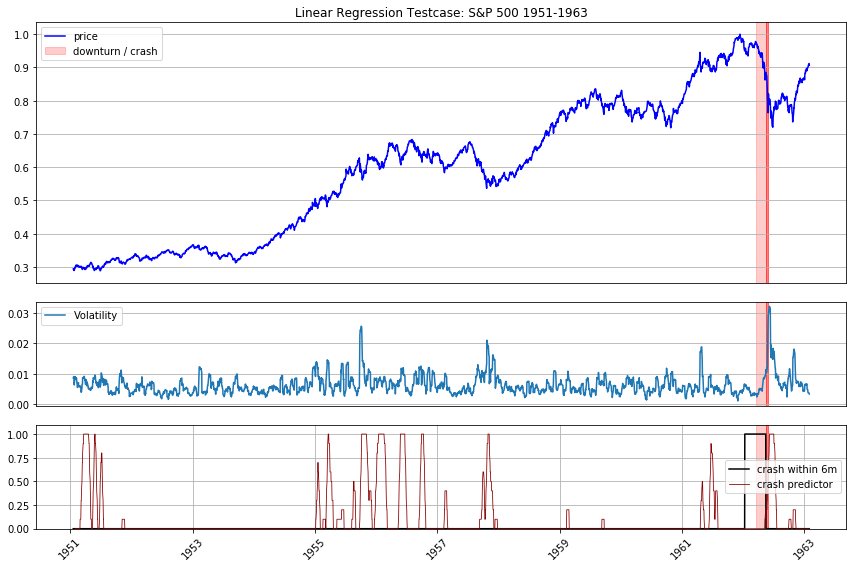

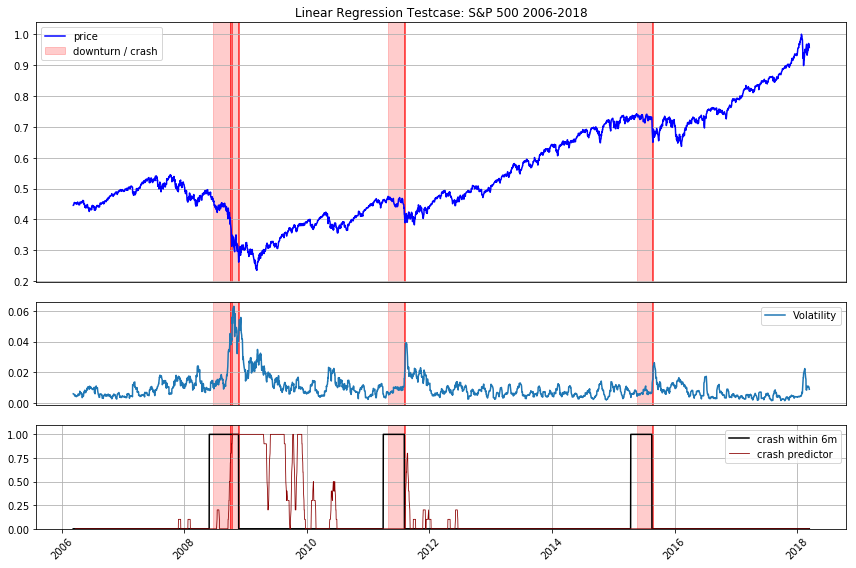

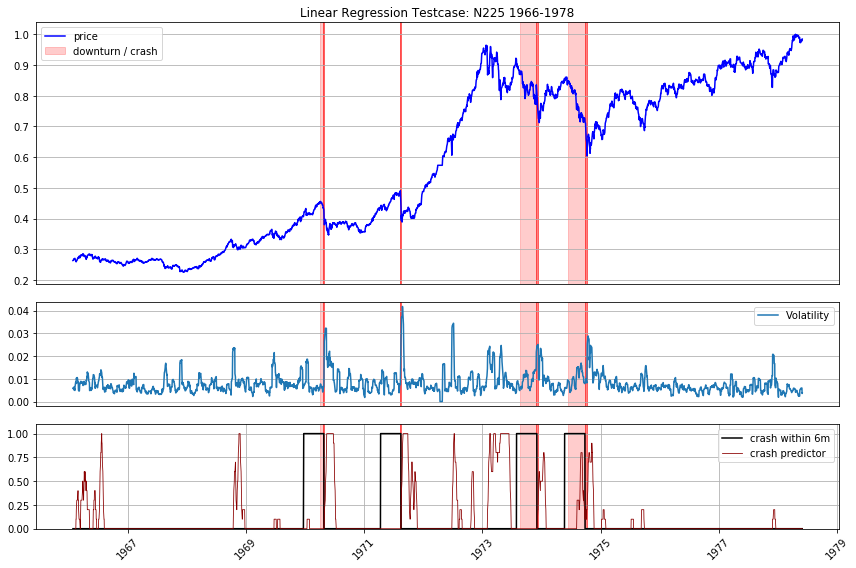

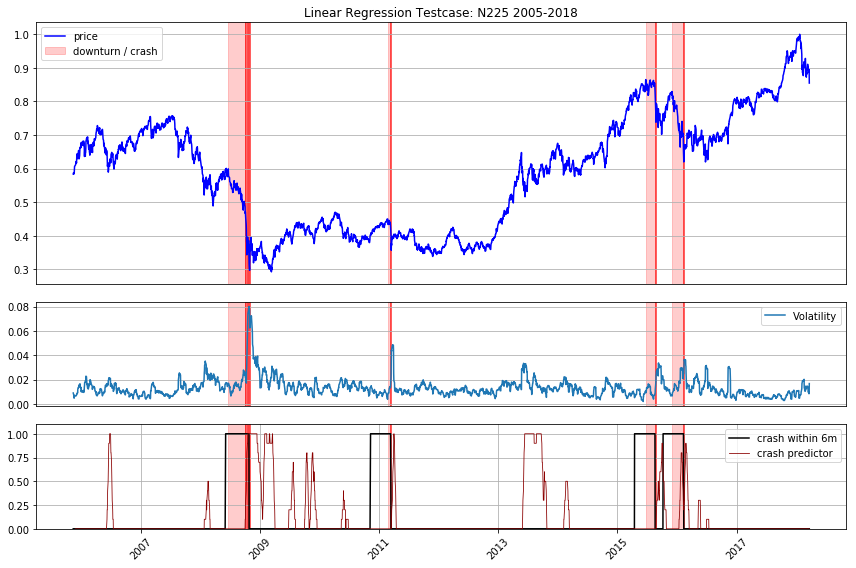

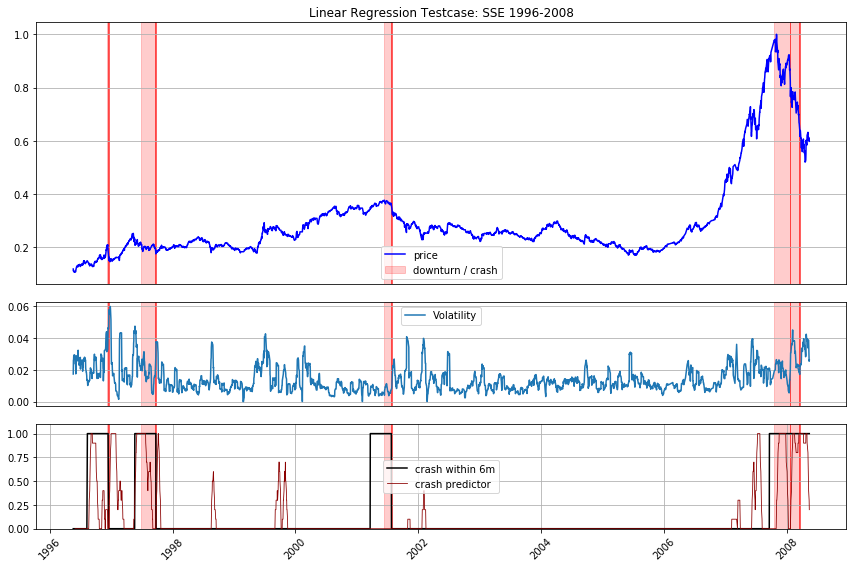

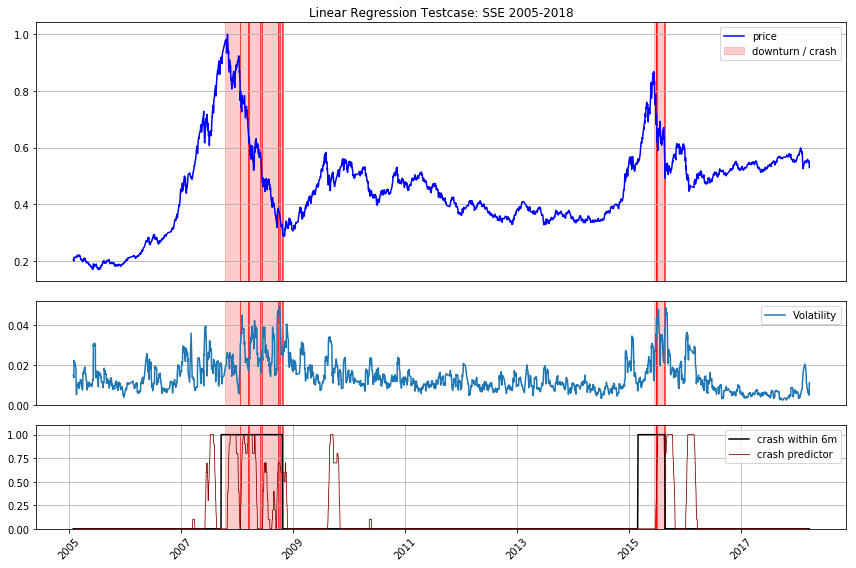

In [8]:
##### Linear regression - Plots for all test cases:
df_combined = [dfc.reindex(dfs.index) for dfc, dfs in zip(df_combined, dfs_xy)]
dfs_predict = []
for j in range(6):
    i = round(j/2 + 0.1)
    k = round(j/2 - 0.1)
    if j % 2 == 0:
        df = df_combined[k].iloc[:n, :]
        df['y_pred'] = y_pred_bin_t_all[j]
        df['y'] = y_actual[j]
        dfs_predict.append(df)
    if j % 2 == 1:       
        df = df_combined[k].iloc[-n:, :]
        df['y_pred'] = y_pred_bin_t_all[j]
        df['y'] = y_actual[j]
        dfs_predict.append(df)
cr_ext = []
for c in crashes:
    cr_ext.append(c)
    cr_ext.append(c)
ds_name_ext = []
for ds_name in dataset_names:
    ds_name_ext.append(ds_name)
    ds_name_ext.append(ds_name)    
gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1]) 
for df, c, t in zip(dfs_predict, cr_ext, ds_name_ext):
    t1 = df.index[0]
    t2 = df.index[-1]
    plt.subplot(gs[0])
    down_st = list(filter(lambda x: x > t1 and x < t2, c['down_st']))
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + t + ' ' + str(df.index[0].year) + '-' \
              + str(df.index[-1].year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  

In [12]:
########################### SVM Classifier linear ########################### 
# define, train and test model:
model_name = 'SVM: Linear Classification'
clf = svm.SVC(C=1, kernel='linear', class_weight='balanced')#'rbf: radial basis function

precision_tr = []
recall_tr = []
accuracy_tr = []
precision_t = []
recall_t = []
accuracy_t = []
y_pred_bin_t_all = []  #<- store all test predictions here
y_actual = []
for train, test in zip(np_train, np_test):
    x_tr = train[:, 0:16]
    y_tr = train[:, 17].astype(int)  #<- crash as response variable
    x_t = test[:, 0:16]
    y_t = test[:, 17].astype(int)
    y_actual.append(y_t)
    model = clf.fit(x_tr, y_tr)
    y_pred_bin_tr = model.predict(x_tr)
    precision_tr.append(metrics.precision_score(y_tr, y_pred_bin_tr))
    recall_tr.append(metrics.recall_score(y_tr, y_pred_bin_tr))
    accuracy_tr.append(metrics.accuracy_score(y_tr, y_pred_bin_tr))
    y_pred_bin_t = model.predict(x_t)
    y_pred_bin_t_all.append(y_pred_bin_t)  #<- list of test predictions for plots
    precision_t.append(metrics.precision_score(y_t, y_pred_bin_t))
    recall_t.append(metrics.recall_score(y_t, y_pred_bin_t))
    accuracy_t.append(metrics.accuracy_score(y_t, y_pred_bin_t))
# score: square of loss, multiplied by wtd over precision, recall, accuracy
avg_pr_tr = sum(precision_tr)/len(precision_tr)
avg_re_tr = sum(recall_tr)/len(recall_tr)
avg_ac_tr = sum(accuracy_tr)/len(accuracy_tr)
avg_pr_t = sum(precision_t)/len(precision_t)
avg_re_t = sum(recall_t)/len(recall_t)
avg_ac_t = sum(accuracy_t)/len(accuracy_t)
wtd_pr = 0.325
wtd_re = 0.375
wtd_ac = 0.3
score_tr = (1-(wtd_pr*(1-avg_pr_tr)**2+wtd_re*(1-avg_re_tr)**2+wtd_ac*(1-avg_ac_tr)**2))*100
score_t = (1-(wtd_pr*(1-avg_pr_t)**2+wtd_re*(1-avg_re_t)**2+wtd_ac*(1-avg_ac_t)**2))*100
print('Results ' + model_name + ':')
print('Number of features: ' + str(dfs_xy[0].shape[1]-2) + '; number of rows: ' \
      + str(np_xy.shape[0]))
print('Avg precision train: ' + str(round(avg_pr_tr, 2)))
print('Avg recall train:    ' + str(round(avg_re_tr, 2)))
print('Avg accuracy train:  ' + str(round(avg_ac_tr, 2)))
print('Score train:         ' + str(round(score_tr)))
print('Avg precision test:  ' + str(round(avg_pr_t, 2)))
print('Avg recall test:     ' + str(round(avg_re_t, 2)))
print('Avg accuracy test:   ' + str(round(avg_ac_t, 2)))
print('Score test:          ' + str(round(score_t)))

Results SVM: Linear Classification:
Number of features: 16; number of rows: 34978
Avg precision train: 0.14
Avg recall train:    0.28
Avg accuracy train:  0.82
Score train:         55.0
Avg precision test:  0.13
Avg recall test:     0.35
Avg accuracy test:   0.78
Score test:          59.0


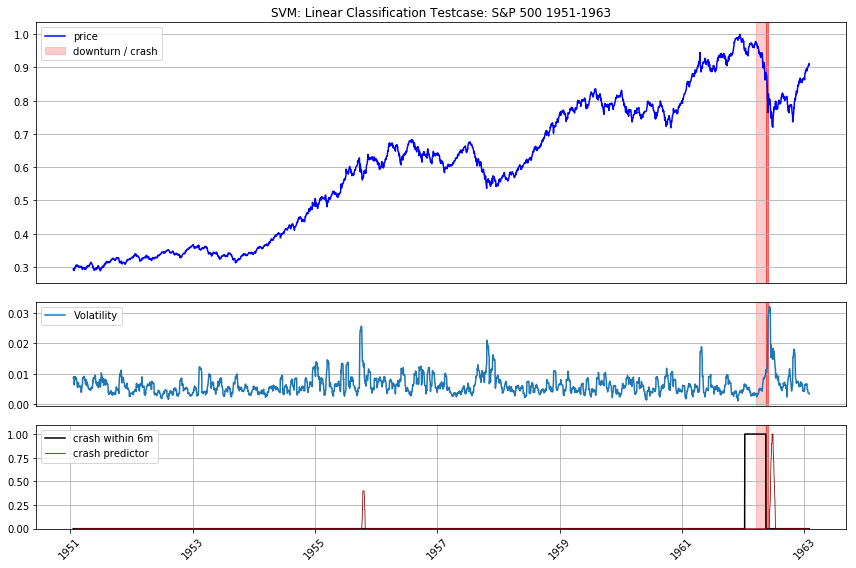

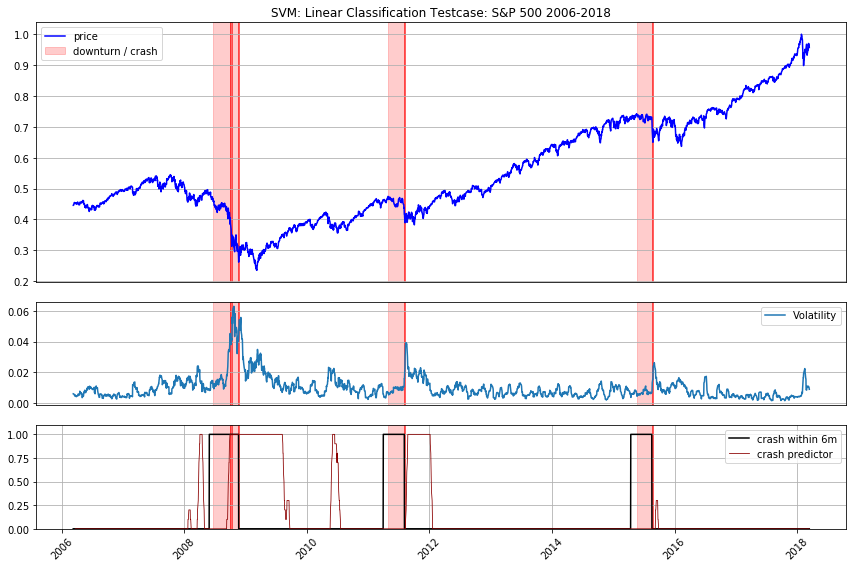

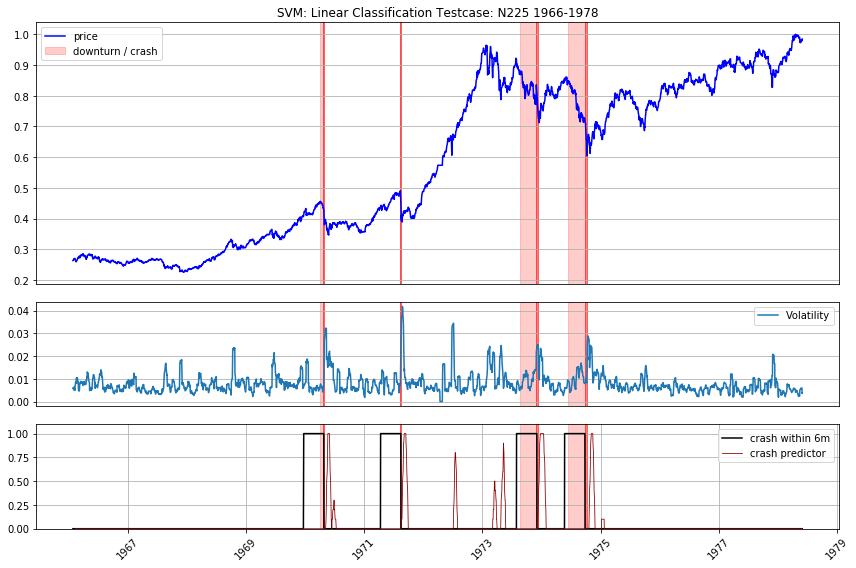

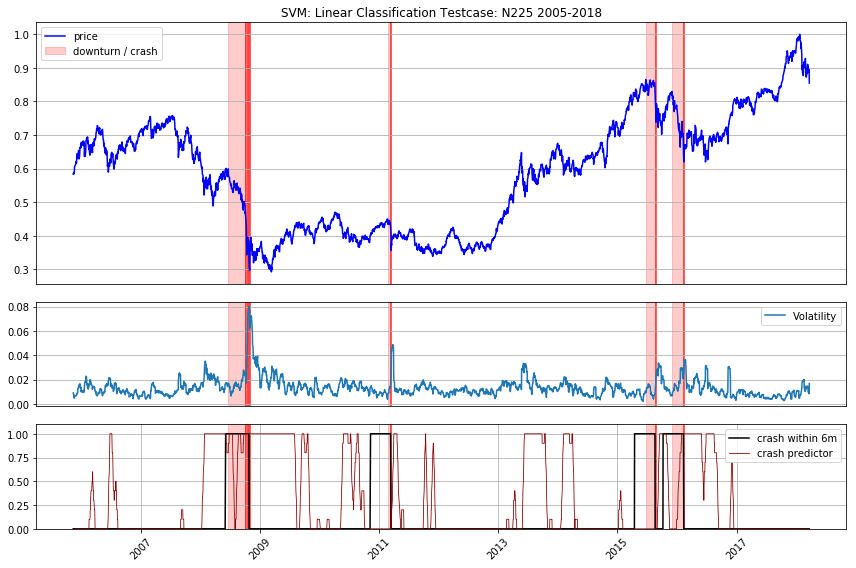

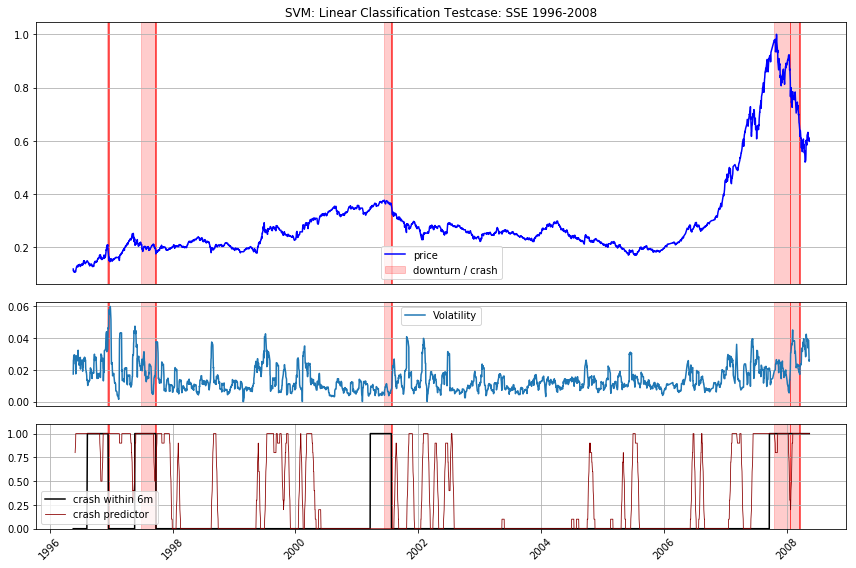

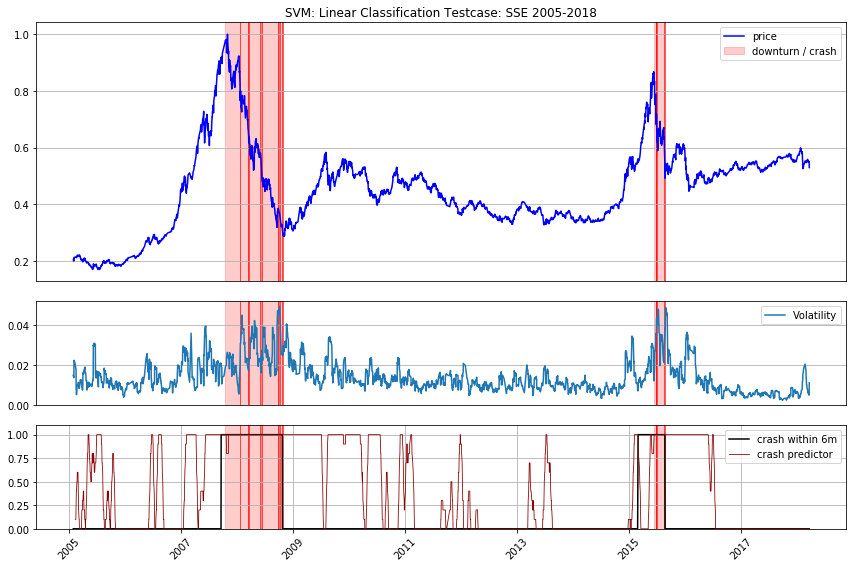

In [13]:
##### SVM classifier linear - Prepare plots for all test cases:
df_combined = [dfc.reindex(dfs.index) for dfc, dfs in zip(df_combined, dfs_xy)]
dfs_predict = []
for j in range(6):
    i = round(j/2 + 0.1)
    k = round(j/2 - 0.1)
    if j % 2 == 0:
        df = df_combined[k].iloc[:n, :]
        df['y_pred'] = y_pred_bin_t_all[j]
        df['y'] = y_actual[j]
        dfs_predict.append(df)
    if j % 2 == 1:       
        df = df_combined[k].iloc[-n:, :]
        df['y_pred'] = y_pred_bin_t_all[j]
        df['y'] = y_actual[j]
        dfs_predict.append(df)
cr_ext = []
for c in crashes:
    cr_ext.append(c)
    cr_ext.append(c)
ds_name_ext = []
for ds_name in dataset_names:
    ds_name_ext.append(ds_name)
    ds_name_ext.append(ds_name)    
gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1]) 
for df, c, t in zip(dfs_predict, cr_ext, ds_name_ext):
    t1 = df.index[0]
    t2 = df.index[-1]
    plt.subplot(gs[0])
    down_st = list(filter(lambda x: x > t1 and x < t2, c['down_st']))
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + t + ' ' + str(df.index[0].year) + '-' \
              + str(df.index[-1].year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  

In [14]:
########################### SVM Classifier nonlinear ########################### 
# define, train and test model:
model_name = 'SVM: Nonlinear Classification (RBF)'
clf = svm.SVC(C=1, kernel='rbf', class_weight='balanced')#'rbf: radial basis function

precision_tr = []
recall_tr = []
accuracy_tr = []
precision_t = []
recall_t = []
accuracy_t = []
y_pred_bin_t_all = []  #<- store all test predictions here
y_actual = []
for train, test in zip(np_train, np_test):
    x_tr = train[:, 0:16]
    y_tr = train[:, 17].astype(int)  #<- crash as response variable
    x_t = test[:, 0:16]
    y_t = test[:, 17].astype(int)
    y_actual.append(y_t)
    model = clf.fit(x_tr, y_tr)
    y_pred_bin_tr = model.predict(x_tr)
    precision_tr.append(metrics.precision_score(y_tr, y_pred_bin_tr))
    recall_tr.append(metrics.recall_score(y_tr, y_pred_bin_tr))
    accuracy_tr.append(metrics.accuracy_score(y_tr, y_pred_bin_tr))
    y_pred_bin_t = model.predict(x_t)
    y_pred_bin_t_all.append(y_pred_bin_t)  #<- list of test predictions for plots
    precision_t.append(metrics.precision_score(y_t, y_pred_bin_t))
    recall_t.append(metrics.recall_score(y_t, y_pred_bin_t))
    accuracy_t.append(metrics.accuracy_score(y_t, y_pred_bin_t))
# score: square of loss, multiplied by wtd over precision, recall, accuracy
avg_pr_tr = sum(precision_tr)/len(precision_tr)
avg_re_tr = sum(recall_tr)/len(recall_tr)
avg_ac_tr = sum(accuracy_tr)/len(accuracy_tr)
avg_pr_t = sum(precision_t)/len(precision_t)
avg_re_t = sum(recall_t)/len(recall_t)
avg_ac_t = sum(accuracy_t)/len(accuracy_t)
wtd_pr = 0.325
wtd_re = 0.375
wtd_ac = 0.3
score_tr = (1-(wtd_pr*(1-avg_pr_tr)**2+wtd_re*(1-avg_re_tr)**2+wtd_ac*(1-avg_ac_tr)**2))*100
score_t = (1-(wtd_pr*(1-avg_pr_t)**2+wtd_re*(1-avg_re_t)**2+wtd_ac*(1-avg_ac_t)**2))*100
print('Results ' + model_name + ':')
print('Number of features: ' + str(dfs_xy[0].shape[1]) + '; number of rows: ' \
      + str(np_xy.shape[0]))
print('Avg precision train: ' + str(round(avg_pr_tr, 2)))
print('Avg recall train:    ' + str(round(avg_re_tr, 2)))
print('Avg accuracy train:  ' + str(round(avg_ac_tr, 2)))
print('Score train:         ' + str(round(score_tr)))
print('Avg precision test:  ' + str(round(avg_pr_t, 2)))
print('Avg recall test:     ' + str(round(avg_re_t, 2)))
print('Avg accuracy test:   ' + str(round(avg_ac_t, 2)))
print('Score test:          ' + str(round(score_t)))

Results SVM: Nonlinear Classification (RBF):
Number of features: 18; number of rows: 34978
Avg precision train: 0.25
Avg recall train:    0.17
Avg accuracy train:  0.89
Score train:         55.0
Avg precision test:  0.16
Avg recall test:     0.25
Avg accuracy test:   0.85
Score test:          56.0


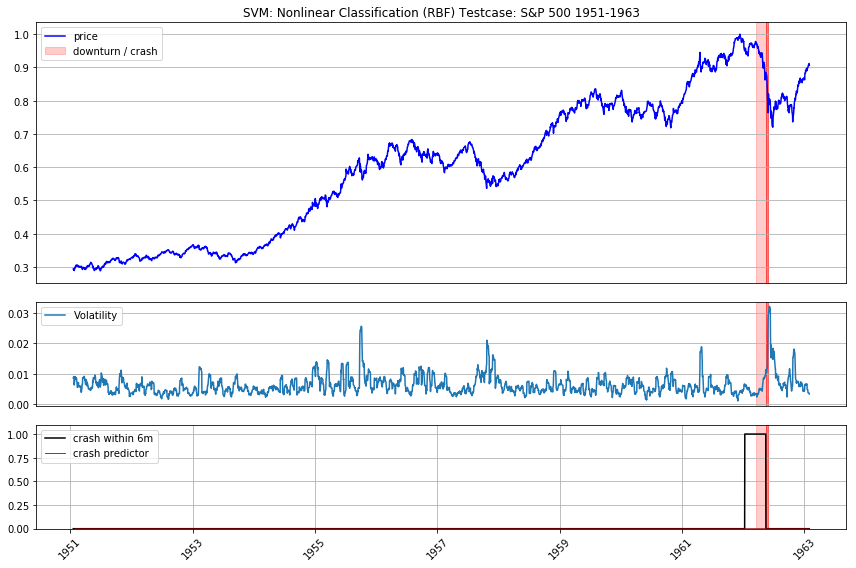

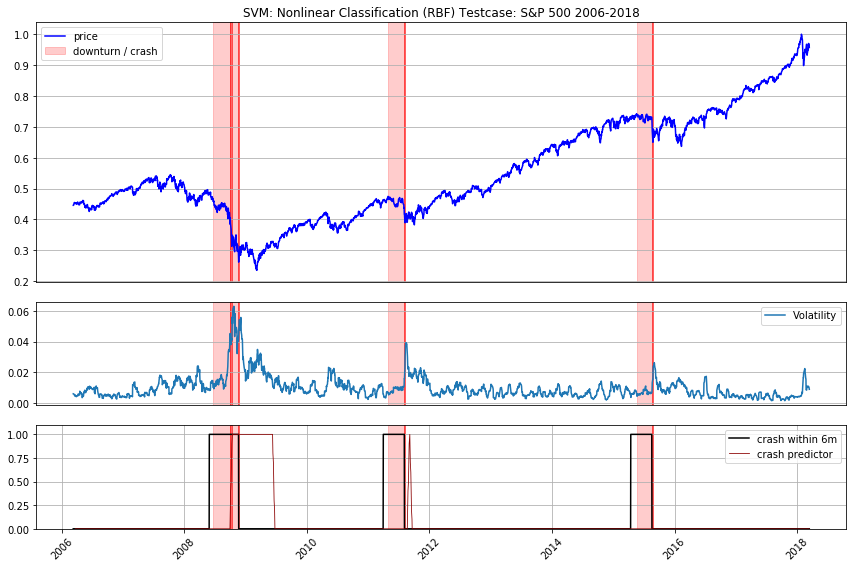

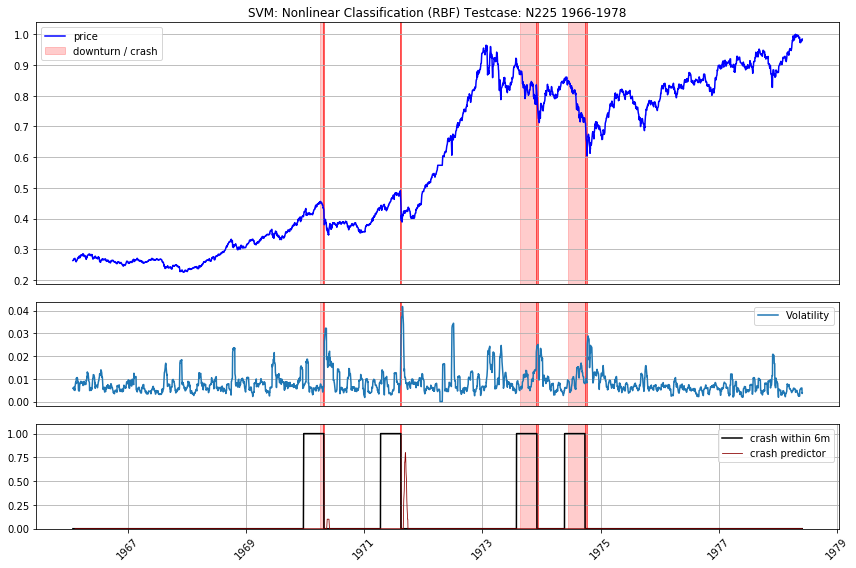

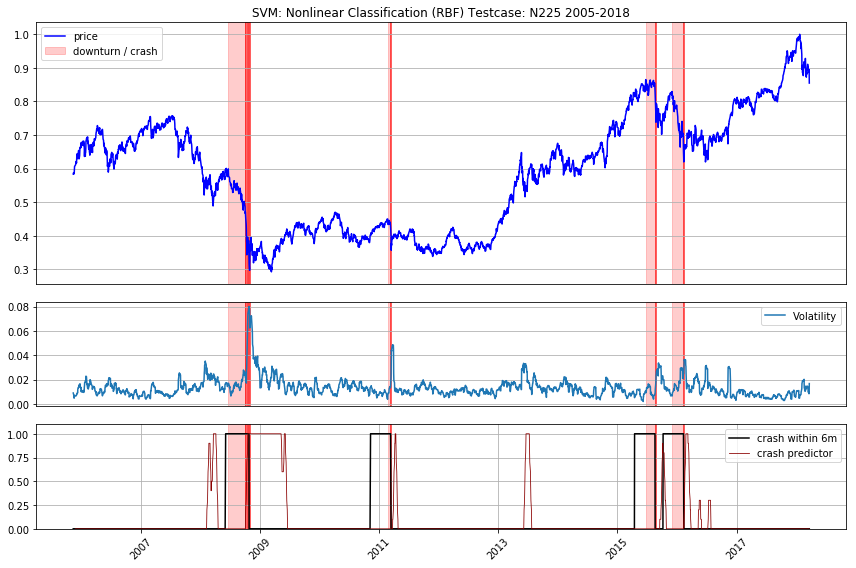

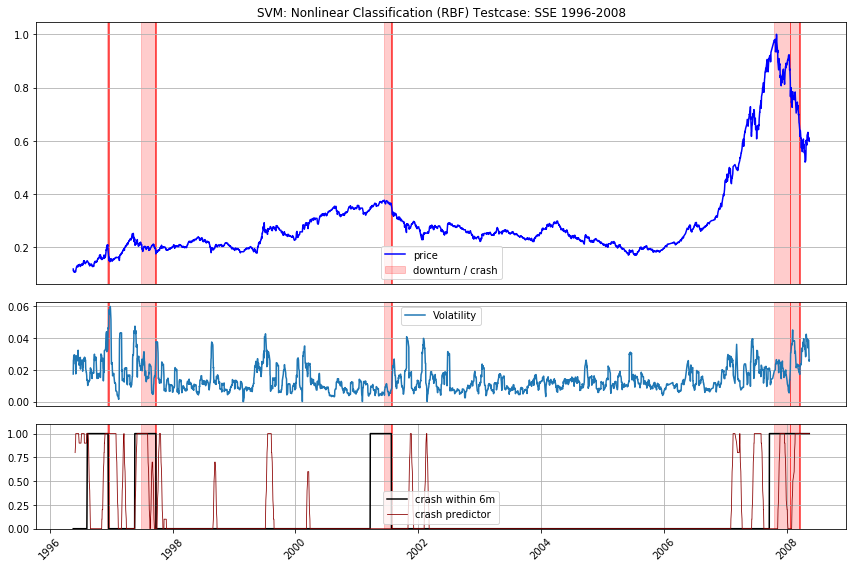

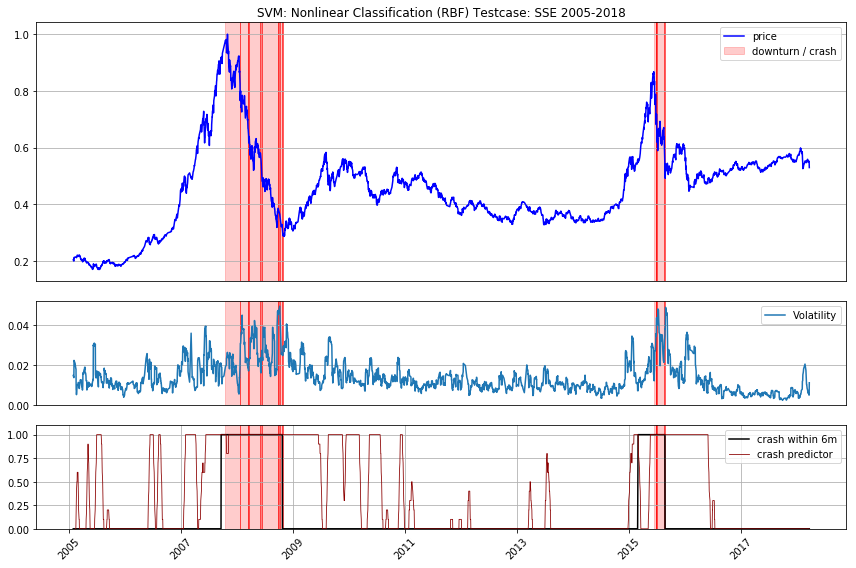

In [15]:
##### SVM classifier nonlinear -Prepare plots for all test cases:
df_combined = [dfc.reindex(dfs.index) for dfc, dfs in zip(df_combined, dfs_xy)]
dfs_predict = []
for j in range(6):
    i = round(j/2 + 0.1)
    k = round(j/2 - 0.1)
    if j % 2 == 0:
        df = df_combined[k].iloc[:n, :]
        df['y_pred'] = y_pred_bin_t_all[j]
        df['y'] = y_actual[j]
        dfs_predict.append(df)
    if j % 2 == 1:       
        df = df_combined[k].iloc[-n:, :]
        df['y_pred'] = y_pred_bin_t_all[j]
        df['y'] = y_actual[j]
        dfs_predict.append(df)
cr_ext = []
for c in crashes:
    cr_ext.append(c)
    cr_ext.append(c)
ds_name_ext = []
for ds_name in dataset_names:
    ds_name_ext.append(ds_name)
    ds_name_ext.append(ds_name)    
gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1]) 
for df, c, t in zip(dfs_predict, cr_ext, ds_name_ext):
    t1 = df.index[0]
    t2 = df.index[-1]
    plt.subplot(gs[0])
    down_st = list(filter(lambda x: x > t1 and x < t2, c['down_st']))
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + t + ' ' + str(df.index[0].year) + '-' \
              + str(df.index[-1].year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  

In [16]:
########################### Decision Tree ########################### 
model_name = 'Decision Tree'
clf = tree.DecisionTreeClassifier()

precision_tr = []
recall_tr = []
accuracy_tr = []
precision_t = []
recall_t = []
accuracy_t = []
y_pred_bin_t_all = []  #<- store all test predictions here
y_actual = []
for train, test in zip(np_train, np_test):
    x_tr = train[:, 0:16]
    y_tr = train[:, 17].astype(int)  #<- crash as response variable
    x_t = test[:, 0:16]
    y_t = test[:, 17].astype(int)
    y_actual.append(y_t)
    model = clf.fit(x_tr, y_tr)
    y_pred_bin_tr = model.predict(x_tr)
    precision_tr.append(metrics.precision_score(y_tr, y_pred_bin_tr))
    recall_tr.append(metrics.recall_score(y_tr, y_pred_bin_tr))
    accuracy_tr.append(metrics.accuracy_score(y_tr, y_pred_bin_tr))
    y_pred_bin_t = model.predict(x_t)
    y_pred_bin_t_all.append(y_pred_bin_t)  #<- list of test predictions for plots
    precision_t.append(metrics.precision_score(y_t, y_pred_bin_t))
    recall_t.append(metrics.recall_score(y_t, y_pred_bin_t))
    accuracy_t.append(metrics.accuracy_score(y_t, y_pred_bin_t))
# score: square of loss, multiplied by wtd over precision, recall, accuracy
avg_pr_tr = sum(precision_tr)/len(precision_tr)
avg_re_tr = sum(recall_tr)/len(recall_tr)
avg_ac_tr = sum(accuracy_tr)/len(accuracy_tr)
avg_pr_t = sum(precision_t)/len(precision_t)
avg_re_t = sum(recall_t)/len(recall_t)
avg_ac_t = sum(accuracy_t)/len(accuracy_t)
wtd_pr = 0.325
wtd_re = 0.375
wtd_ac = 0.3
score_tr = (1-(wtd_pr*(1-avg_pr_tr)**2+wtd_re*(1-avg_re_tr)**2+wtd_ac*(1-avg_ac_tr)**2))*100
score_t = (1-(wtd_pr*(1-avg_pr_t)**2+wtd_re*(1-avg_re_t)**2+wtd_ac*(1-avg_ac_t)**2))*100
print('Results ' + model_name + ':')
print('Number of features: ' + str(dfs_xy[0].shape[1]) + '; number of rows: ' \
      + str(np_xy.shape[0]))
print('Avg precision train: ' + str(round(avg_pr_tr, 2)))
print('Avg recall train:    ' + str(round(avg_re_tr, 2)))
print('Avg accuracy train:  ' + str(round(avg_ac_tr, 2)))
print('Score train:         ' + str(round(score_tr)))
print('Avg precision test:  ' + str(round(avg_pr_t, 2)))
print('Avg recall test:     ' + str(round(avg_re_t, 2)))
print('Avg accuracy test:   ' + str(round(avg_ac_t, 2)))
print('Score test:          ' + str(round(score_t)))

Results Decision Tree:
Number of features: 18; number of rows: 34978
Avg precision train: 1.0
Avg recall train:    1.0
Avg accuracy train:  1.0
Score train:         100.0
Avg precision test:  0.14
Avg recall test:     0.11
Avg accuracy test:   0.83
Score test:          46.0


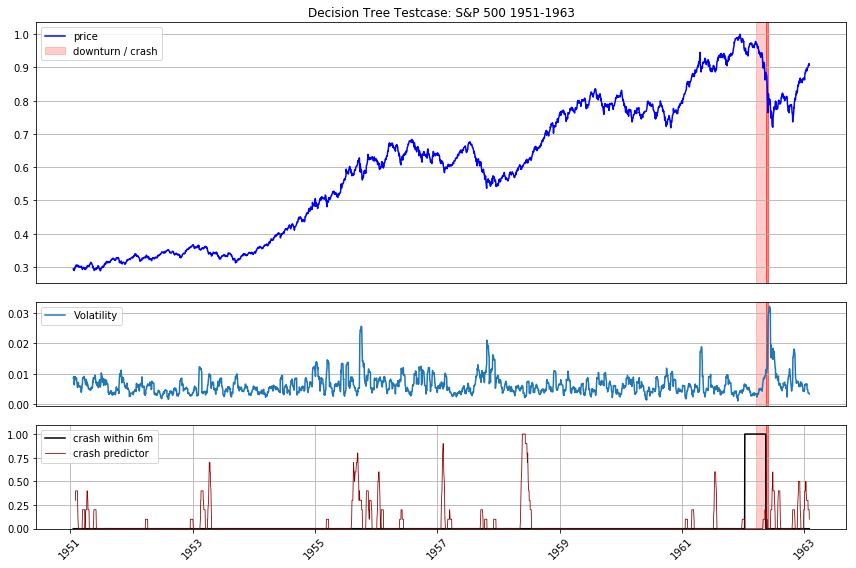

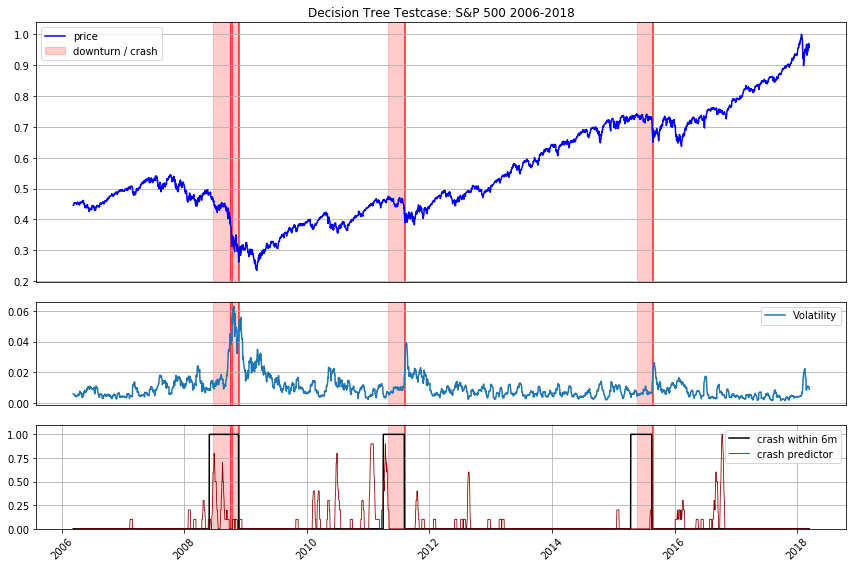

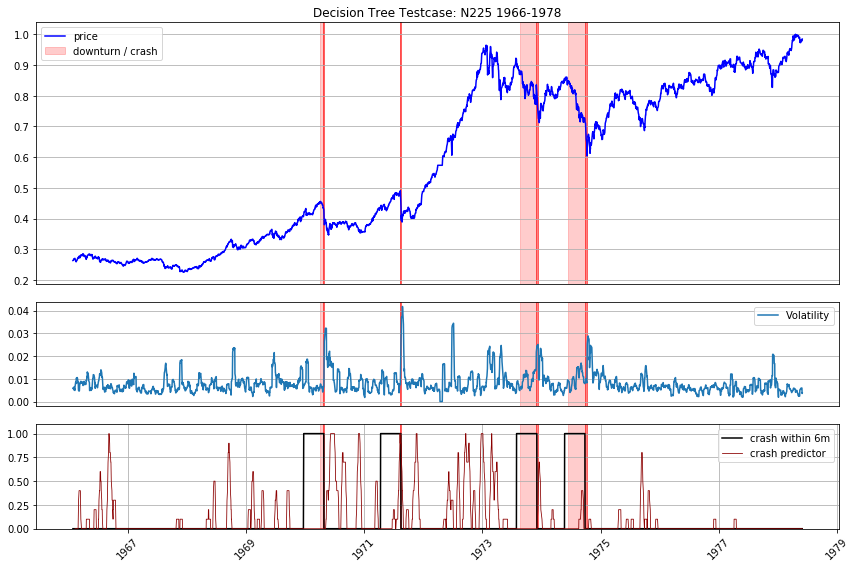

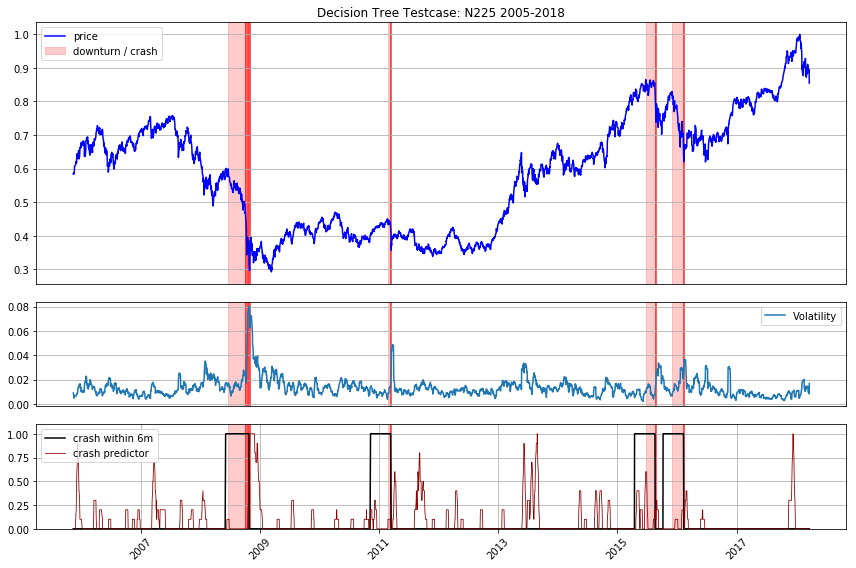

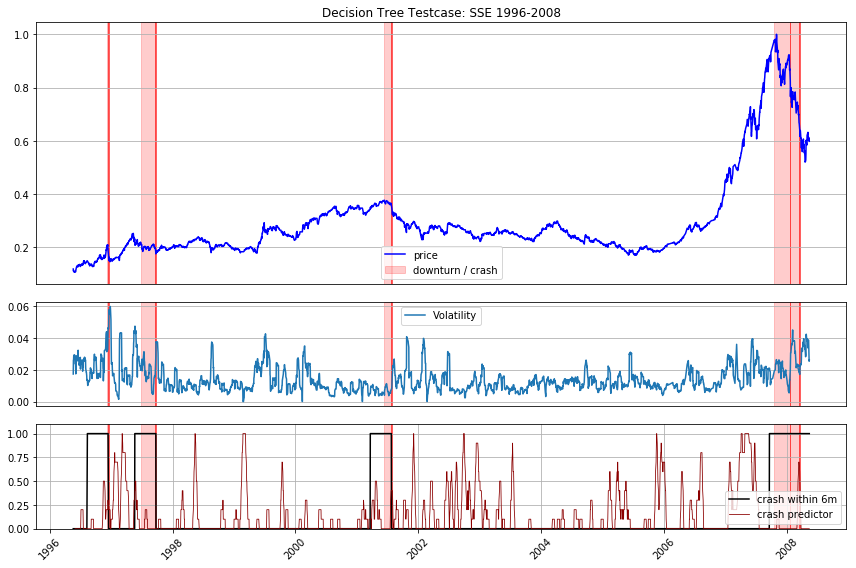

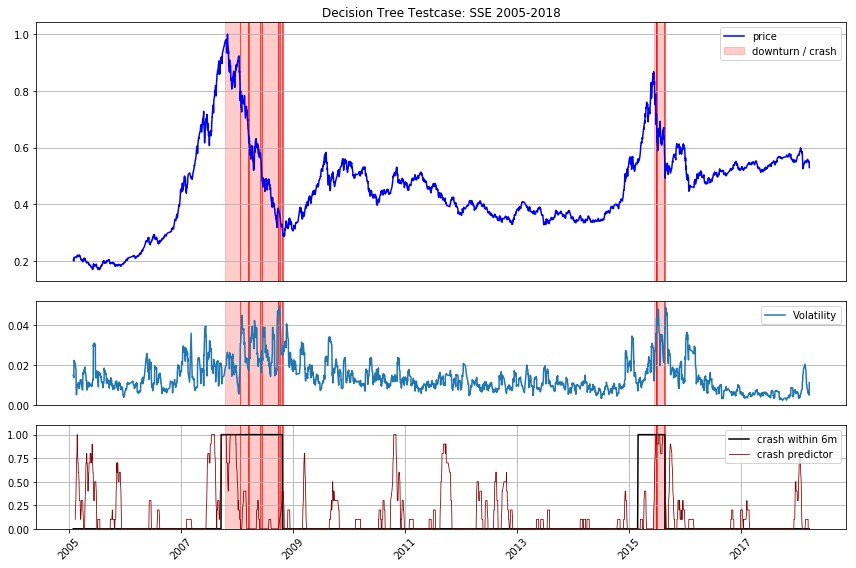

In [17]:
##### Decision tree - Prepare plots for all test cases:
df_combined = [dfc.reindex(dfs.index) for dfc, dfs in zip(df_combined, dfs_xy)]
dfs_predict = []
for j in range(6):
    i = round(j/2 + 0.1)
    k = round(j/2 - 0.1)
    if j % 2 == 0:
        df = df_combined[k].iloc[:n, :]
        df['y_pred'] = y_pred_bin_t_all[j]
        df['y'] = y_actual[j]
        dfs_predict.append(df)
    if j % 2 == 1:       
        df = df_combined[k].iloc[-n:, :]
        df['y_pred'] = y_pred_bin_t_all[j]
        df['y'] = y_actual[j]
        dfs_predict.append(df)
cr_ext = []
for c in crashes:
    cr_ext.append(c)
    cr_ext.append(c)
ds_name_ext = []
for ds_name in dataset_names:
    ds_name_ext.append(ds_name)
    ds_name_ext.append(ds_name)    
gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1]) 
for df, c, t in zip(dfs_predict, cr_ext, ds_name_ext):
    t1 = df.index[0]
    t2 = df.index[-1]
    plt.subplot(gs[0])
    down_st = list(filter(lambda x: x > t1 and x < t2, c['down_st']))
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + t + ' ' + str(df.index[0].year) + '-' \
              + str(df.index[-1].year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  